# mapping with cartopy

In the first practical for EGM711, you learned how to use ArcGIS Pro to make maps, given shapefiles of different features of interest in Northern Ireland. In this practical, you will repeat the exercise, this time using `cartopy`, `geopandas`, and `matplotlib`, three python packages used for making maps, working with vector data, and making plots, respectively. 

## objectives
- become familiar with geopandas, cartopy, and matplotlib, including reading the provided documentation
- use list comprehensions to simplify some for loops

## getting started
First, run the cell below to load the python modules we'll be using in the practical.

1. the built-in help (i.e., `help(plt.text)`)
2. using ipython's (the python interpreter used by jupyter-notebooks) help shortcut (i.e., `plt.text?`)
3. finding the online documentation for the module (usually achieved via option 4)
4. searching google (or your search engine of choice)
5. consulting your favorite medicine man/shaman/spiritual guide
6. asking the instructor, who will in all likelihood resort to one of the other options (usually 5 or 4).

In [1]:
# this lets us use the figures interactively
%matplotlib inline

import os
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion() # make the plotting interactive

Let's also define a few helper functions that we'll use later on. For now, don't worry too much about what each individual line does - we'll go over these in a bit more depth as we go. Remember also that if you get stuck, you can get help in a few ways:

In [2]:
# generate matplotlib handles to create a legend of each of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = [] # create an empty list
    for ii in range(len(labels)): # for each label and color pair that we're given, make an empty box to pass to our legend
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[ii % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent() # get the current extent of the axis
    sbx = x0 + (x1 - x0) * location[0] # get the lower left x coordinate of the scale bar
    sby = y0 + (y1 - y0) * location[1] # get the lower left y coordinate of the scale bar

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection) # plot a thick black line, 20 km long
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection) # plot a smaller black line from 0 to 10 km long
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection) # plot a white line from 10 to 20 km

    ax.text(sbx, sby-5000, '20 km', transform=ax.projection, fontsize=8) # add a label at 20 km
    ax.text(sbx-12500, sby-5000, '10 km', transform=ax.projection, fontsize=8) # add a label at 10 km
    ax.text(sbx-24500, sby-5000, '0 km', transform=ax.projection, fontsize=8) # add a label at 0 km

    return ax

## loading the data
Great. Now that we've imported most of the modules we'll be needing, and defined a few helper functions, we can actually load our data. To load the shapefile data, we will use [GeoPandas](http://geopandas.org/), an open-source package designed to make working with geospatial data in python easier. 

GeoPandas is built off of Pandas, a powerful data analysis tool. We will be working with both of these packages more in the weeks to come.

To open a shapefile, we use the `gpd.read_file()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html)) method:

In [3]:
outline = gpd.read_file(os.path.abspath('data_files/NI_outline.shp'))
towns = gpd.read_file(os.path.abspath('data_files/Towns.shp'))
water = gpd.read_file(os.path.abspath('data_files/Water.shp'))
rivers = gpd.read_file(os.path.abspath('data_files/Rivers.shp'))
counties = gpd.read_file(os.path.abspath('data_files/Counties.shp'))

GeoPandas loads the data associated with a shapefile into a GeoDataFrame, a tabular data structure that always has a column describing a feature's geometry. As we saw in last week's exercise, each line in the table corresponds to a feature in the shapefile, just like the attribute table you are familiar with from ArcGIS/QGIS.

To see a subset of a GeoDataFrame, we can use the ``head()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)) method:

In [4]:
water.head(10)

,OBJECTID,localId,namespace,spZoneType,Area_km2,Shape_STAr,Shape_STLe,geometry
0,426,UKGBNI3NB0032,Lough Neagh,lakeWaterBody,381.26885,3.812689e+08,229598.416210,"POLYGON ((697663.597 890293.350, 697668.266 89..."
1,427,UKGBNI3NB0018,Lough Gullion,lakeWaterBody,0.87955,8.795458e+05,4566.067559,"POLYGON ((700271.885 862035.746, 700275.974 86..."
2,428,UKGBNI3NB0034,Stonyford Reservoir,lakeWaterBody,0.55215,5.521490e+05,3362.846807,"POLYGON ((721939.978 870023.040, 721941.528 87..."
3,429,UKGBNI3NB0016,Portmore Lough,lakeWaterBody,1.82020,1.820205e+06,6145.560653,"POLYGON ((711384.568 868267.925, 711374.252 86..."
4,430,UKGBNI3NW0036,Castlehume Lough,lakeWaterBody,0.60717,6.071743e+05,5483.032678,"POLYGON ((619303.183 850890.988, 619305.732 85..."
5,431,UKGBNI3NE0028,Lough Mourne,lakeWaterBody,0.50854,5.085364e+05,3822.843162,"POLYGON ((740847.269 893437.583, 740851.568 89..."
6,432,UKGBNI3NB0035,Lough Beg,lakeWaterBody,4.55217,4.552165e+06,35140.854769,"POLYGON ((698745.423 897612.948, 698749.272 89..."
7,433,UKGBNI3NB0026,Spelga Dam,lakeWaterBody,0.62042,6.204161e+05,4299.846208,"POLYGON ((726738.948 827272.259, 726747.876 82..."
8,434,UKGBNI3NB0027,Lough Fea,lakeWaterBody,0.62423,6.242300e+05,4468.608674,"POLYGON ((675479.251 887607.767, 675479.575 88..."
9,435,UKGBNI3NB0017,Lough Island Reavey,lakeWaterBody,1.02915,1.029149e+06,5361.774281,"POLYGON ((729075.912 834584.799, 729082.741 83..."


To select rows in the dataframe using an index, we can use ``.loc`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)):

In [5]:
water.loc[0] # should show the row for Lough Neagh

OBJECTID                                                    426
localId                                           UKGBNI3NB0032
namespace                                           Lough Neagh
spZoneType                                        lakeWaterBody
Area_km2                                              381.26885
Shape_STAr                                        381268852.195
Shape_STLe                                         229598.41621
geometry      POLYGON ((697663.5969669062 890293.3504859076,...
Name: 0, dtype: object

Note that ``.loc`` is not a method, since we use square brackets:`[` and `]`, instead of round brackets/parentheses. Instead, it's an attribute that provides a way to index or slice a GeoDataFrame.

We can also use ``.loc`` with **conditional statements**. For example, if we wanted to select all bodies of water that are smaller than 1 square kilometer, we could use something like this:

In [6]:
water.loc[water['Area_km2'] < 1]

,OBJECTID,localId,namespace,spZoneType,Area_km2,Shape_STAr,Shape_STLe,geometry
1,427,UKGBNI3NB0018,Lough Gullion,lakeWaterBody,0.87955,879545.755661,4566.067559,"POLYGON ((700271.885 862035.746, 700275.974 86..."
2,428,UKGBNI3NB0034,Stonyford Reservoir,lakeWaterBody,0.55215,552149.025482,3362.846807,"POLYGON ((721939.978 870023.040, 721941.528 87..."
4,430,UKGBNI3NW0036,Castlehume Lough,lakeWaterBody,0.60717,607174.288490,5483.032678,"POLYGON ((619303.183 850890.988, 619305.732 85..."
5,431,UKGBNI3NE0028,Lough Mourne,lakeWaterBody,0.50854,508536.425438,3822.843162,"POLYGON ((740847.269 893437.583, 740851.568 89..."
7,433,UKGBNI3NB0026,Spelga Dam,lakeWaterBody,0.62042,620416.085281,4299.846208,"POLYGON ((726738.948 827272.259, 726747.876 82..."
8,434,UKGBNI3NB0027,Lough Fea,lakeWaterBody,0.62423,624230.017395,4468.608674,"POLYGON ((675479.251 887607.767, 675479.575 88..."
10,436,UKGBNI3NE0023,Clea Lakes,lakeWaterBody,0.65294,652941.158401,11785.580844,"POLYGON ((750791.366 855851.750, 750786.497 85..."
11,438,UKGBNI3NE0019,Silent Valley Reservoir,lakeWaterBody,0.94689,946894.198784,7411.632700,"POLYGON ((730590.819 824816.169, 730594.312 82..."
12,439,UKGBNI3NB0020,Lough Ross Monaghan,lakeWaterBody,0.84295,842953.498520,5579.426838,"POLYGON ((687927.101 816230.362, 687930.550 81..."
16,450,UKGBNI3NB0021,Cam Lough,lakeWaterBody,0.71845,718449.277115,6301.291972,"POLYGON ((702526.866 825927.708, 702540.886 82..."


Note that with only a single value, `.loc` returns all columns of the GeoDataFrame where the rows match the given index/conditional statement. 

To select a specific column or group of columns, we can use a comma to separate the different indexers. For example, if we want to select only the name of the lakes that are smaller than 1 square kilometer, we can use the following:

In [7]:
water.loc[water['Area_km2'] < 1, 'namespace']

1               Lough Gullion
2         Stonyford Reservoir
4            Castlehume Lough
5                Lough Mourne
7                  Spelga Dam
8                   Lough Fea
10                 Clea Lakes
11    Silent Valley Reservoir
12        Lough Ross Monaghan
16                  Cam Lough
20              Lough Scolban
Name: namespace, dtype: object

Each "column" of the GeoDataFrame is an object of type **Series** ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.html)).

If a **Series** is filled with numeric data, we can use different methods such as ``.sum()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.sum.html)) or ``.mean()`` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.mean.html)), to get the sum and mean of the values in the **Series**, respectively. So, the total area (in square kilometers) of all of the lakes in the dataset would be given by the following statement:

In [8]:
water['Area_km2'].sum()

570.30457

We'll work with GeoDataFrames more in next week's practical, but for now see if you can put these different pieces together and figure out the total area of lakes in the `Water` dataset that are smaller than 10 square kilometers. I'll provide a few reminder hints to get you started:

1. **GeoDataFrame**s can be subset using both a conditional and a column in the **GeoDataFrame**, like we saw above.
2. With only a single value, `.loc` returns all columns of the GeoDataFrame where the rows match the given index/slice/conditional statement. To select a specific column or group of columns, we can use a comma to separate the different indexers.
3. The numerical columns of a GeoDataFrame (also called Series or GeoSeries) have built-in operators such as __max__, __min__, __mean__, and so on.

That should be enough to get you started - if you get stuck, be sure to ask for help.

In [9]:
lake10 = water.loc[water['Area_km2'] < 10, 'Area_km2']

totalarea = lake10.sum()

print(lake10)
print(totalarea)

1     0.87955
2     0.55215
3     1.82020
4     0.60717
5     0.50854
6     4.55217
7     0.62042
8     0.62423
9     1.02915
10    0.65294
11    0.94689
12    0.84295
13    9.88507
15    4.18977
16    0.71845
20    0.65551
Name: Area_km2, dtype: float64
29.085160000000002


## working with coordinate reference systems

Now that we're more familiar with the dataset, we can start building our map. For this portion of the practical, we'll be mostly using [matplotlib](https://matplotlib.org/), a python package designed for making plots and graphs, and [cartopy](https://scitools.org.uk/cartopy/docs/latest/), a package designed for making maps and representing geopatial data.

First, let's look at the coordinate reference system (CRS) for `counties`, the outlines of each of the six counties of Northern Ireland:

In [10]:
counties.crs # show the CRS of the counties dataset

<Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Here, we can see that the county outlines are geographic coordinates, corresponding to WGS84 Latitude/Longitude. Now, let's look at the CRS for `water`, corresponding to the lake outlines:

In [11]:
water.crs

<Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Here, we can see the CRS is different - the coordinates of `water` are in Irish Transverse Mercator, which are very different to WGS84 Latitude/Longitude.

To correctly plot our geospatial data, then, we need to have some way for `cartopy` and `matplotlib` to "translate" and plot the coordinates stored within the shapefile data - this way, even if our data are represented in different coordinates (e.g., WGS84 Latitude/Longitude or Irish Transverse Mecractor), they will show up in the correct places on the map.

To do this, we need to create a `cartopy` **CRS**, a representation of the spatial reference system that we will use to plot our data inside of our map. Here, we're using `ccrs.UTM()` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#utm)) to create a CRS corresponding to the Universal Transverse Mercator (UTM) Zone that Northern Ireland is part of. In order for this line to work, you will need to replace `XX` with the correct number for the UTM Zone that Northern Ireland is part of - if you're not sure, [this website](https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#) provides an interactive way for you to find the "best" UTM Zone for any given location.

In [12]:
ni_utm = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the UTM Zone that Northern Ireland is part of.

We can also use `ccrs.CRS()` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.crs.CRS.html)), along with the `.crs` attribute of a **GeoDataFrame**, in order to create a `cartopy` **CRS** that can be used with other `cartopy` functions and objects:

In [13]:
ccrs.CRS(outline.crs) # create a cartopy CRS representation of the CRS associated with the outline dataset

<Projected CRS: EPSG:32629>
Name: WGS 84 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°W and 6°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Côte D'Ivoire (Ivory Coast). Faroe Islands. Guinea. Ireland. Jan Mayen. Liberia, Mali. Mauritania. Morocco. Portugal. Sierra Leone. Spain. United Kingdom (UK). Western Sahara.
- bounds: (-12.01, 0.0, -6.0, 84.01)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We'll use this, along with the `.crs` attributes of our datasets, in order to plot everything in the correct location as we add items to our map.

To create the map, we start by using `plt.figure()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)), along with the `figsize` argument, to create a new **Figure** object. The **Figure** is the container that we use to create different plots, such as our map.

While the **Figure** is the container that we use to create different plots, these plots are actually displayed by an object called an **Axes** - the "artist" that will actually draw the plot. Here, we're using `plt.axes()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axes.html)) to create an empty **Axes** on the current **Figure**. 

We use the `projection` keyword argument along with our **CRS** object to set the **Axes**' projection to be our UTM Zone - this way, we can be sure that the data that we pass to the **Axes** in order to plot are shown in the correct location:

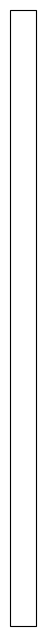

In [14]:
myFig = plt.figure(figsize=(8, 8))  # create a figure of size 8x8 (representing the page size in inches)
ax = plt.axes(projection=ni_utm)  # create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

As you can see, the **Axes** starts off blank - we haven't added anything to it yet.

## adding data to the map

Now that we've created a figure and axes, we can start adding data to the map. To start, we'll add the municipal borders. 

In order to add these to the map, we first have to create features that we can add to the axes using the `ShapelyFeature` class ([documenation](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.feature.ShapelyFeature.html#cartopy.feature.ShapelyFeature)) from `cartopy.feature` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/feature.html)). 

The initialization method for this class takes a minimum of two arguments: an __iterable__ containing the geometries that we're using, and a CRS representation corresponding to the coordinate reference system of those geometries. 

To add the County borders, then, we can use `counties['geometry']`, the **GeoSeries** of the feature geometries in our outline shapefile, and `outline.crs`, the CRS attribute of that shapefile:

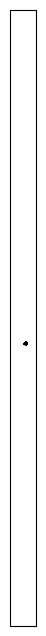

In [15]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], ni_utm, edgecolor='k', facecolor='w')
ax.add_feature(outline_feature) # add the features we've created to the map.

myFig

The other arguments that we pass to `ShapelyFeature` tell `matplotlib` how to draw the features - in this case, with an edge color (`edgecolor`) of black (`'k'`) and a face color (`facecolor`) of white (`'w'`). Once we've created the features, we add them to the axes using the `add_feature` method.

As you can see from the output above, we have added the outline to the map, but it's very zoomed out (by default, it displays the *entire* UTM Zone, stretching from the Equator to the North Pole). We can zoom the map into our area of interest by using the boundary of the shapefile features along with `.set_extent()` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html#cartopy.mpl.geoaxes.GeoAxes.set_extent)). 

First, we get the boundary of the shapefile features using `.total_bounds` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)), then use these values when we call `.set_extent()`. In the example below, we're setting the extent with a 5 km buffer around each edge:

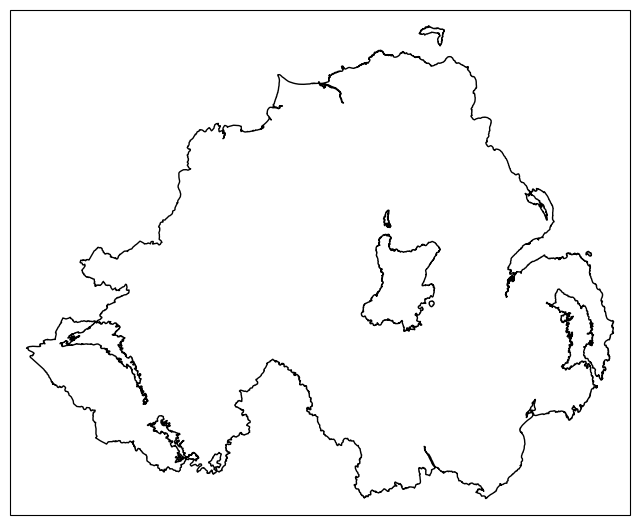

In [16]:
xmin, ymin, xmax, ymax = outline.total_bounds # using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=ni_utm) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

myFig ## re-draw the figure (only for the notebook)

This is a fine start to our map, but a bit boring. For one thing, we might want to set different colors for the different county outlines, rather than having them all be the same color. To do this, we'll first have to count the number of __unique__ counties in our dataset, then select colors to represent each of them. 


<span style="color:blue;font-weight:bold;font-size:14pt">Question: Why might we do this, rather than just use the number of features in the dataset?</span>


Run the cell below to count the number of unique municipalities in the dataset, using the `unique` method on the __CountyName__ GeoSeries. 

Note that in addition to the standard indexing (i.e., `counties['CountyName']`), we are accessing __CountyName__ directly as an attribute of `counties` (i.e., `counties.CountyName`). Provided that the column name follows particular rules ([more on this here](http://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access)), there is no difference between these two methods - they give the same results.

In [17]:
# get the number of unique municipalities we have in the dataset
num_counties = len(counties.CountyName.unique())
print(f'Number of unique features: {num_counties}') # note how we're using an f-string with {} here!

Number of unique features: 6


Now that you've found the number of colors you need to choose, you can use the image below to make a list of the colors. There are other ways to select colors using matplotlib, including using RGB values, but that's for another day. If you're interested in learning more, you can check out the documentation [here](https://matplotlib.org/stable/api/colors_api.html).

![title](imgs/named_colors.png)
[source](https://matplotlib.org/stable/gallery/color/named_colors.html)

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


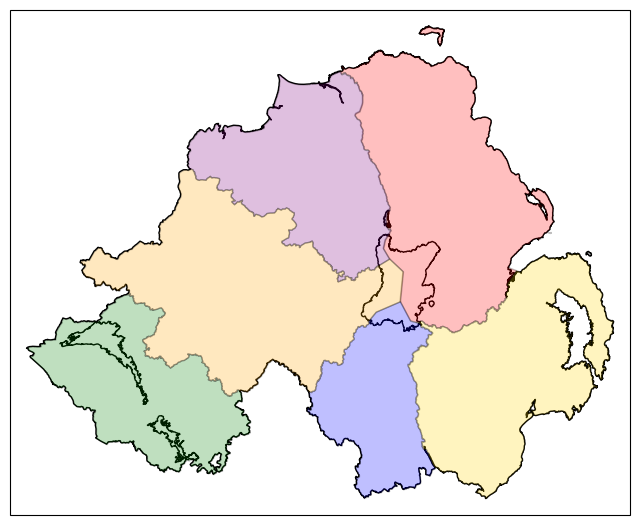

In [18]:
# pick colors for the individual county boundaries - make sure to add enough for each of the counties
# to add a color, enclose the name above (e.g., violet) with single (or double) quotes: 'violet'
# remember that each colors should be separated by a comma
county_colors = ['red', 'blue', 'gold', 'green', 'purple', 'orange', 'cyan']

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort() # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt. 
# Feel free to experiment with different colors and line widths.
for ii, name in enumerate(county_names):
    feat = ShapelyFeature(counties.loc[counties['CountyName'] == name, 'geometry'], # first argument is the geometry
                          ccrs.CRS(counties.crs), # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=county_colors[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.25) # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

myFig # to show the updated figure

In the code above, note this line:

```python
ccrs.CRS(counties.crs) # second argument is the CRS
```

As we saw above, this creates a new cartopy **CRS** object using the `.crs` attribute of the **GeoDataFrame**. If we're not sure that all of our datasets use the same CRS, or we haven't re-projected them all to a single CRS, we can use this to make sure that cartopy uses the correct CRS when displaying each dataset on the map.

Now that we've done this for the county boundaries, we can also do this for the water datasets. Because we want each of the water bodies to use the same symbology, we add them with a single use of **ShapelyFeature**:

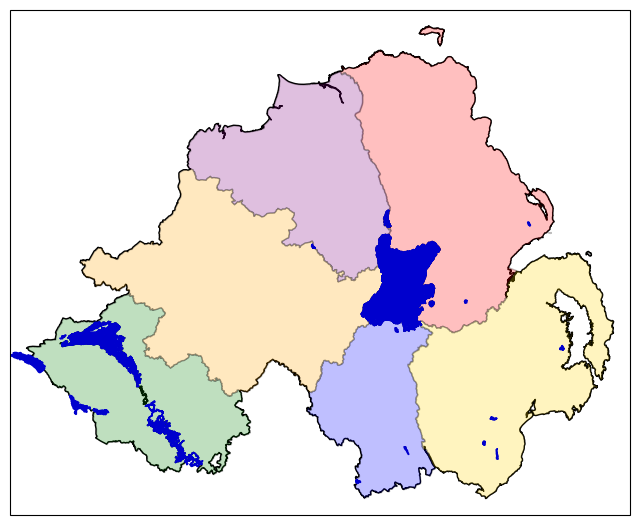

In [19]:
# here, we're setting the edge color to be the same as the face color. Feel free to change this around,
# and experiment with different line widths.
water_feat = ShapelyFeature(water['geometry'], # first argument is the geometry
                            ccrs.CRS(water.crs), # second argument is the CRS
                            edgecolor='mediumblue', # set the edgecolor to be mediumblue
                            facecolor='mediumblue', # set the facecolor to be mediumblue
                            linewidth=1) # set the outline width to be 1 pt
ax.add_feature(water_feat) # add the collection of features to the map

myFig # to show the updated figure

To add the rivers dataset to the map, we can again use `ShapelyFeature()`, with `ccrs.CRS(rivers.crs)` as the CRS argument. Note that because these are **LineString** objects, not **Polygon**s, we don't set the `facecolor` property.

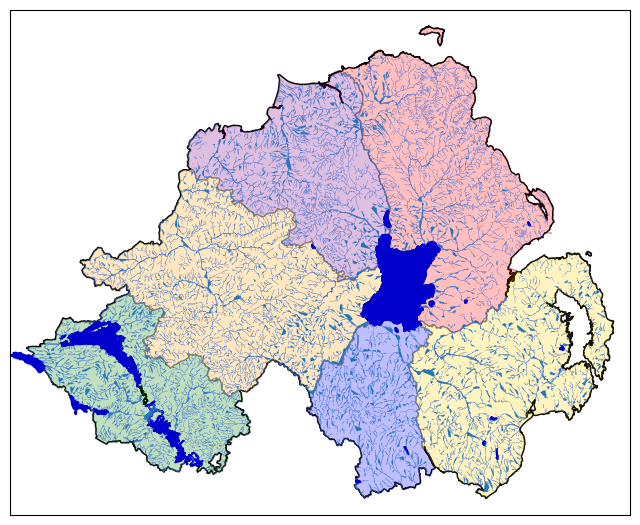

In [20]:
river_feat = ShapelyFeature(rivers['geometry'], # first argument is the geometry
                            ccrs.CRS(rivers.crs), # second argument is the CRS
                            edgecolor='royalblue', # set the edgecolor to be royalblue
                            linewidth=0.2) # set the linewidth to be 0.2 pt
ax.add_feature(river_feat) # add the collection of features to the map

myFig # to show the updated figure

Before we add the `towns` data to the map, let's take a look at the CRS attribute for this dataset:

In [21]:
towns.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Here, we have *geographic* coordinates (WGS84 latitude/longitude), rather than *projected* coordinates (e.g., UTM or Irish Transverse Mercator). Because our map is currently set to a projected coordinate system, we can't simply use `ccrs.CRS()` with the CRS for `towns`, as we have done for the previous few datasets. 

Instead, we can use `ccrs.PlateCarree()` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#platecarree)), or [plate carrée](https://proj.org/en/9.3/operations/projections/eqc.html), which is an *equirectangular projection* that uses latitude/longitude values as the projected x/y values. This way, we are able to plot the geographic coordinates in our projected system.

Because these are **Point** data, we can use `ax.plot()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html)) directly, rather than **ShapelyFeature**.

The code below will add a gray (`color='0.5'`) square (`'s'`) marker of size 6 (`ms=6`) at each x, y location:

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


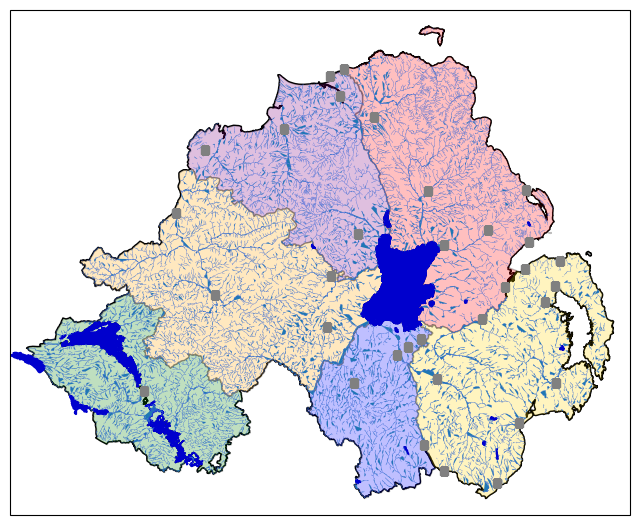

In [22]:
# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=ccrs.PlateCarree()) # towns is in UTM Zone 29N, so we can use ni_utm

myFig # to show the updated figure

## adding labels and legends

Now that we have different colors for each of the county boundaries and we've displayed lakes, rivers, and towns, it might be good to have a legend to keep everything straight.

To do this, we get handles for each of the county boundaries, using the colors we defined earlier. Here, we're using our helper function `generate_handles()`, defined at the beginning of the exercise. This function returns a **list** of `matplotlib` handles (i.e., the identifier that `matplotlib` uses for the different objects in the figure), given a **list** of labels and colors. We will use these handles to create the **legend** for our map, which explains what the different symbols and colors mean.

The cell below will generate **list**s of handles for the counties, water bodies, and rivers:

In [23]:
# generate a list of handles for the county datasets
# first, we add the list of names, then the list of colors, and finally we set the transparency
# (since we set it in the map)
county_handles = generate_handles(counties.CountyName.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
water_handle = generate_handles(['Lakes'], ['mediumblue'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]

Note that the names in our county dataset are all uppercase - that's not necessarily how we want to display them on the map. To change this, we can use a string method, `.title()` ([documentation](https://docs.python.org/3/library/stdtypes.html#str.title)), which capitalizes the first letter of each word in the string. 

We will need to do this for each of the items in our list of names. Now, we *could* write this as a `for` loop, like this:

```python
nice_names = []  # initalize an empty list
for name in county_names:
    nice_names.append(name.title())

```

But, python offers another, cleaner option, called a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). A **list comprehension** allows us to generate a new list from an existing iterable (for example, a **Series**). 

To write the same `for` loop shown above as a list comprehension takes a single line:

In [24]:
# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

That's it. This creates a new list by iterating over each of the items in county_names, applying `.title()` to each item. We'll work more with list comprehensions throughout the module, as they provide a way to simplify some pretty complicated loops.

Finally, we're ready to add our legend using `ax.legend()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html#)).

As you can see from the call signature in the documentation above, we can pass each of our lists of handles and labels to `ax.legend()`, and `matplotlib` will construct the legend based on these inputs. Feel free to modify the legend by changing the placement (for example, by changing the `loc` keyword argument), or the font size, the title font size, or other parameters:

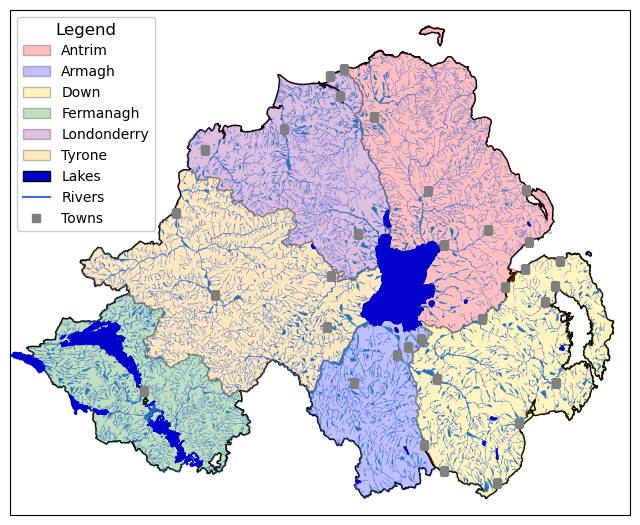

In [25]:
# ax.legend() takes a list of handles and a list of labels corresponding to the objects 
# you want to add to the legend
handles = county_handles + water_handle + river_handle + town_handle # use '+' to concatenate (combine) lists
labels = nice_names + ['Lakes', 'Rivers', 'Towns']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12, 
                 fontsize=10, loc='upper left', frameon=True, framealpha=1)

myFig # to show the updated figure

Now that we have a legend, let's go ahead and add grid lines to our plot using `ax.gridlines()` ([documentation](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html#cartopy.mpl.geoaxes.GeoAxes.gridlines)). Without any arguments, this method will automatically determine the "best" gridlines to use for our map, given the extent, the CRS, and so on. We can also specify where to draw lines using the `xlocs` and `ylocs` keyword arguments, which take an **iterable** of locations to draw along the x and y axis, respectively.

What happens if you delete the first and/or last value from xlocs and ylocs? Try it and see!

Can you change the labels to show *only* on the bottom and left side of the map? To see, try looking at this [example](https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html), or at the documentation linked above.

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


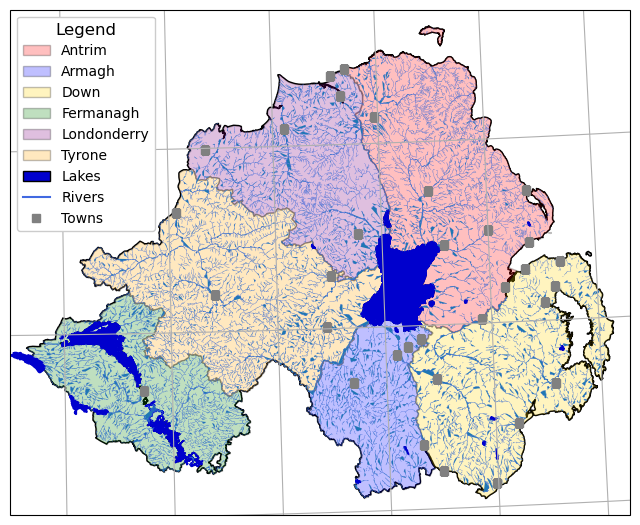

In [26]:
gridlines = ax.gridlines(draw_labels = False,  # draw labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],  # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5])  # add latitude lines at 0.5 deg intervals
gridlines.left_labels = False  # turn off the left-side labels
gridlines.bottom_labels = False  # turn on the bottom labels
gridlines.top_labels = False
gridlines.right_labels = False
myFig  # to show the updated figure



Now, let's add text labels for each of our individual towns. For each of the points representing our towns/cities, we can place a text label using `ax.text()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html)).

Look over the cell below, and make sure you understand what each line is doing. If you're not sure you understand, remember that you can post your questions on Blackboard.

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


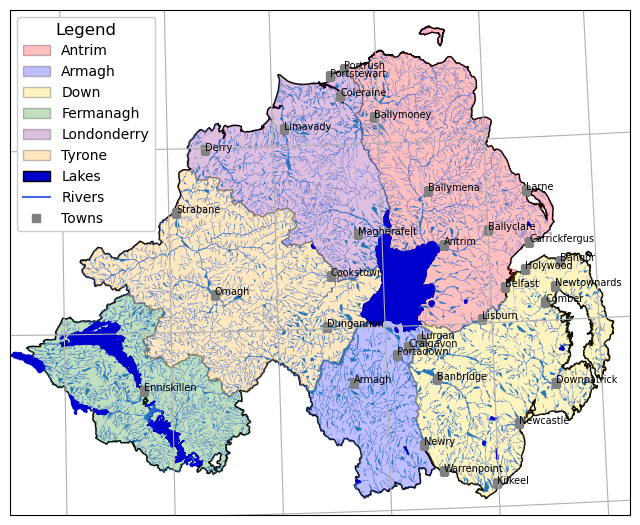

In [27]:
for ind, row in towns.iterrows(): # towns.iterrows() returns the index and row
    x, y = row.geometry.x, row.geometry.y # get the x,y location for each town
    ax.text(x, y, row['TOWN_NAME'].title(), fontsize=7, transform=ccrs.PlateCarree()) # use plt.text to place a label at x,y

myFig # to show the updated figure    

Last but not least, let's add a scale bar to the plot. The `scale_bar()` function we've defined above will produce a scale bar with divisions at 10 and 20 km, with a location in the upper right corner as default:

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


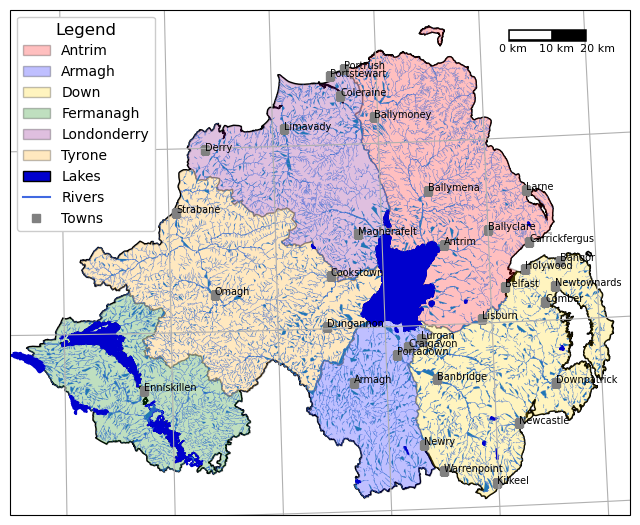

In [28]:
scale_bar(ax) # place a scale bar in the upper right corner of the map window

myFig # to show the updated figure

Finally, we'll save our figure using `.savefig()` ([documentation](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.savefig)). 

The code written below will save the figure to the current folder in a file called `map.png`, with no border around the outside of the map, and with a resolution of 300 dots per inch. As always, feel free to experiment with or change these parameters.

In [29]:
myFig.savefig('map.png', bbox_inches='tight', dpi=300)

C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\ProgramData\anaconda3\envs\EGM722\Lib\site-packages\cartopy\mpl\feature_artist.py:151: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


## further exercises and next steps

In this directory, you should also have a python script, **practical2_script.py**, which will create the same map that we've made here (though perhaps with different colors). For some additional practice, try at least one of the following:

- The `towns` dataset has an attribute, **STATUS**, that describes whether the feature represents a "Town" (e.g., Coleraine), or a "City" (e.g., Belfast). Modify the script to plot all of the **Towns** with one marker (e.g., the gray square used above), and plot all of the **Cities** with a different marker, then add each of these to the legend. For more information on the available markers and colors for matplotlib, see the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).
- Try to modify the `scale_bar()` function to have divisions at 1, 5, and 10 km, instead of at 10 km.